This notebook refer from the solution got Top 1 at the challenge: [Embryo classification based on microscopic images](https://www.kaggle.com/competitions/world-championship-2023-embryo-classification/overview)
- Source: https://www.kaggle.com/code/plephu/phamlephu-gk

In [1]:
import albumentations
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
import numpy as np


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd

data_train = pd.read_csv('/kaggle/input/new-embryo-split/train.csv')
data_val = pd.read_csv('/kaggle/input/new-embryo-split/val.csv')
data_test =pd.read_csv('/kaggle/input/new-embryo-split/test.csv')
data_train.shape, data_val.shape, data_test.shape


((2150, 2), (538, 2), (168, 2))

In [3]:
data_path = '/kaggle/input/new-embryo-split/train_aug-20240126T142651Z-001/train_aug/'
data_train['Image'] = data_train['Image'].apply(lambda x: data_path + x.split('/')[-1])
data_val['Image'] = data_val['Image'].apply(lambda x: data_path + x.split('/')[-1])

data_train.head()

,Image,Class
0,/kaggle/input/new-embryo-split/train_aug-20240...,0
1,/kaggle/input/new-embryo-split/train_aug-20240...,0
2,/kaggle/input/new-embryo-split/train_aug-20240...,0
3,/kaggle/input/new-embryo-split/train_aug-20240...,0
4,/kaggle/input/new-embryo-split/train_aug-20240...,0


In [4]:
import random
import tensorflow as tf
import os
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(42)

seeding done!!!


<Axes: >

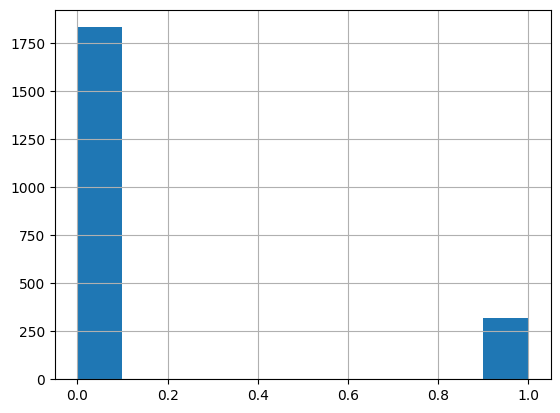

In [5]:
data_train.Class.hist()

In [6]:
# => data is imbalance

In [7]:
train_img_path = '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train'
test_img_path = '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/test'

In [8]:
from PIL import Image
import os
import torch
from sklearn.model_selection import train_test_split

    
# define a data class
class ClassificationDataset:
    def __init__(self, data, data_path, transform, training=True):
        """Define the dataset for classification problems

        Args:
            data ([dataframe]): [a dataframe that contain 2 columns: image name and label]
            data_path ([str]): [path/to/folder that contains image file]
            transform : [augmentation methods and transformation of images]
            training (bool, optional): []. Defaults to True.
        """
        self.data = data
#         self.imgs = data["Image"].unique().tolist()
        self.imgs = data["Image"].tolist()

        self.data_path = data_path
        self.training = training
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        if(self.training):
            label = self.data['Class'][idx]
        if self.transform is not None:
            img = self.transform(img)
        if(self.training):
            return img, label
        else:
            return img

    def __len__(self):
        return len(self.imgs)


def make_loader(dataset, train_batch_size, validation_split=0.2):
    """make dataloader for pytorch training

    Args:
        dataset ([object]): [the dataset object]
        train_batch_size ([int]): [training batch size]
        validation_split (float, optional): [validation ratio]. Defaults to 0.2.

    Returns:
        [type]: [description]
    """
    # number of samples in train and test set
    train_len = int(len(dataset) * (1 - validation_split))
    test_len = len(dataset) - train_len
    train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
    # create train_loader
    print(len(train_set))
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=train_batch_size, shuffle=True,
    )
    # create test_loader
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False,)
    return train_loader, test_loader


def data_split(data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        data, data["label"], test_size=test_size, random_state=42, stratify = data.iloc[:,1]
    )
    return x_train, x_test, y_train, y_test

# 1. Define DataLoader

In [9]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

In [10]:
import torchvision

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)])

In [11]:
test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)])

In [12]:
bs = 16 # batch size

In [13]:
data_val

,Image,Class
0,/kaggle/input/new-embryo-split/train_aug-20240...,0
1,/kaggle/input/new-embryo-split/train_aug-20240...,0
2,/kaggle/input/new-embryo-split/train_aug-20240...,0
3,/kaggle/input/new-embryo-split/train_aug-20240...,0
4,/kaggle/input/new-embryo-split/train_aug-20240...,0
...,...,...
533,/kaggle/input/new-embryo-split/train_aug-20240...,1
534,/kaggle/input/new-embryo-split/train_aug-20240...,0
535,/kaggle/input/new-embryo-split/train_aug-20240...,0
536,/kaggle/input/new-embryo-split/train_aug-20240...,0


In [14]:
dataset = ClassificationDataset(data_train,data_path = "",transform=transform,training=True)
# train_loader,val_loader = make_loader(dataset, train_batch_size=bs, validation_split=0.2)
train_loader = torch.utils.data.DataLoader(dataset,batch_size = bs, shuffle = True)
val_dataset = ClassificationDataset(data_val,data_path = "",transform=test_transform,training=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
# val_dataloader_d3 = DataLoader(valid_data_d3,batch_size = BATCH_SIZE, shuffle = False)

In [15]:
D3 = data_train['Image'].apply(lambda x: 'D3_' in x)
data_train_d3 = data_train[D3].reset_index().drop(['index'], axis=1)
dataset_d3 = ClassificationDataset(data_train_d3,data_path = "",transform=transform,training=True)
train_loader_d3 = torch.utils.data.DataLoader(dataset_d3,batch_size = bs, shuffle = True)

D5 = data_train['Image'].apply(lambda x: 'D5_' in x)
data_train_d5 = data_train[D5].reset_index().drop(['index'], axis=1)
dataset_d5 = ClassificationDataset(data_train_d5,data_path = "",transform=transform,training=True)
train_loader_d5 = torch.utils.data.DataLoader(dataset_d5,batch_size = bs, shuffle = True)

In [16]:
D3 = data_val['Image'].apply(lambda x: 'D3_' in x)
data_val_d3 = data_val[D3].reset_index().drop(['index'], axis=1)
val_dataset_d3 = ClassificationDataset(data_val_d3,data_path = "",transform=test_transform,training=True)
val_loader_d3 = torch.utils.data.DataLoader(val_dataset_d3, batch_size=1, shuffle=False)
D5 = data_val['Image'].apply(lambda x: 'D5_' in x)
data_val_d5 = data_val[D5].reset_index().drop(['index'], axis=1)
val_dataset_d5 = ClassificationDataset(data_val_d5,data_path = "",transform=test_transform,training=True)
val_loader_d5 = torch.utils.data.DataLoader(val_dataset_d5, batch_size=1, shuffle=False)

In [18]:
testset = ClassificationDataset(data_test,data_path = "",transform=test_transform,training=True)
test_loader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False,
    )


In [19]:
D3 = data_test['Image'].apply(lambda x: 'D3_' in x)
data_test_d3 = data_test[D3].reset_index().drop(['index'], axis=1)
test_dataset_d3 = ClassificationDataset(data_test_d3,data_path = "",transform=test_transform,training=True)
test_loader_d3 = torch.utils.data.DataLoader(test_dataset_d3, batch_size=1, shuffle=False)
D5 = data_test['Image'].apply(lambda x: 'D5_' in x)
data_test_d5 = data_test[D5].reset_index().drop(['index'], axis=1)
test_dataset_d5 = ClassificationDataset(data_test_d5,data_path = "",transform=test_transform,training=True)
test_loader_d5 = torch.utils.data.DataLoader(test_dataset_d5, batch_size=1, shuffle=False)

In [21]:
from tqdm import tqdm
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, _ in tqdm(test_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

count = len(data_test) * 224 * 224

# mean and std
test_mean = psum / count
test_var  = (psum_sq / count) - (test_mean ** 2)
test_std  = torch.sqrt(test_var)

100%|██████████| 168/168 [00:02<00:00, 74.54it/s]


In [22]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs,_ in tqdm(train_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

count = len(train_loader) * 224 * 224

# mean and std
train_mean = psum / count
train_var  = (psum_sq / count) - (train_mean ** 2)
train_std  = torch.sqrt(train_var)

100%|██████████| 135/135 [00:14<00:00,  9.14it/s]


In [23]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs,_ in tqdm(train_loader_d3):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

count = len(train_loader) * 224 * 224

# mean and std
train_mean = psum / count
train_var  = (psum_sq / count) - (train_mean ** 2)
train_std  = torch.sqrt(train_var)

100%|██████████| 90/90 [00:04<00:00, 18.99it/s]


# 2. Define Metrics and Optimizers and Loss function


In [24]:
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict

In [25]:
train_metrics = Metrics(["accuracy_score","f1_score"])
val_metrics = Metrics(["accuracy_score","f1_score"])

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch import nn
# criterion = nn.CrossEntropyLoss()

In [28]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(data_train.Class),
                                        y = data_train.Class                                                   
                                    )
#class_weights = dict(zip(np.unique(data_train.label), class_weights))
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
class_weights

tensor([0.5865, 3.3912], device='cuda:0')

In [29]:
class_weights_d3 = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(data_train_d3.Class),
                                        y = data_train_d3.Class                                                   
                                    )
#class_weights = dict(zip(np.unique(data_train.label), class_weights))
class_weights_d3=torch.tensor(class_weights_d3,dtype=torch.float).to(device)

class_weights_d5 = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(data_train_d5.Class),
                                        y = data_train_d5.Class                                                   
                                    )
#class_weights = dict(zip(np.unique(data_train.label), class_weights))
class_weights_d5=torch.tensor(class_weights_d5,dtype=torch.float).to(device)
print(class_weights_d3)
class_weights_d5

tensor([ 0.5203, 12.7946], device='cuda:0')


tensor([0.7862, 1.3736], device='cuda:0')

In [30]:
criterion = nn.CrossEntropyLoss(weight = class_weights)
criterion_d3 = nn.CrossEntropyLoss(weight = class_weights_d3)
criterion_d5 = nn.CrossEntropyLoss(weight = class_weights_d5)

4. Define the Model: Transfer Learning


In [31]:
from torchvision import models
from torch import nn
model = models.mobilenet_v2(pretrained=True).cuda()
for param in model.parameters():
    param.requires_grad = True
classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=256,bias=True),
    nn.Linear(in_features=256, out_features=2,bias=True)
)
model.classifier  = classifier

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.5MB/s]


In [32]:
model_d3 = models.mobilenet_v2(pretrained=True).cuda()
for param in model_d3.parameters():
    param.requires_grad = True
model_d3.classifier  = classifier

model_d5 = models.mobilenet_v2(pretrained=True).cuda()
for param in model_d5.parameters():
    param.requires_grad = True
model_d5.classifier  = classifier

In [33]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.5
    )

optimizer_d3 = torch.optim.Adam(model_d3.classifier.parameters(), lr=0.01)
scheduler_d3 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_d3, "min", patience=2, factor=0.5
    )

optimizer_d5 = torch.optim.Adam(model_d5.classifier.parameters(), lr=0.01)
scheduler_d5 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_d5, "min", patience=2, factor=0.5
    )

# 3. Define a training epoch


In [34]:
model = model.to(device)
model_d3 = model_d3.to(device)
model_d5 = model_d5.to(device)

In [35]:
def train_one_epoch(
    model,
    train_loader,
    test_loader,
    device,
    optimizer,
    criterion,
    train_metrics,
    val_metrics,
):

    # training-the-model
    train_loss = 0
    valid_loss = 0
    all_labels = []
    all_preds = []
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU
        data = data.type(torch.FloatTensor).to(device)
        # target=torch.Tensor(target)
        target = target.float().to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        # get the prediction label and target label
        output = model(data)
        preds = torch.argmax(output, axis=1).cpu().detach().numpy()
        labels = target.cpu().numpy()
        # calculate-the-batch-loss
        loss = criterion(output.type(torch.FloatTensor).to(device), target.type(torch.LongTensor).to(device))
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # calculate training metrics
        all_labels.extend(labels)
        all_preds.extend(preds)
    
    train_metrics.step(all_labels, all_preds)

    # validate-the-model
    model.eval()
    all_labels = []
    all_preds = []
    for data, target in test_loader:
        data = data.type(torch.FloatTensor).to(device)
        target = target.to(device)
        output = model(data)
        preds = torch.argmax(output, axis=1).tolist()
        labels = target.tolist()
        all_labels.extend(labels)
        all_preds.extend(preds)
        loss = criterion(output, target)

        # update-average-validation-loss
        valid_loss += loss.item() * data.size(0)

    val_metrics.step(all_labels, all_preds)
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)

    return (
        train_loss,
        valid_loss,
        train_metrics.last_step_metrics(),
        val_metrics.last_step_metrics(),
    )

In [37]:
import json 
import logging
import numpy as np
def train(model, train_loader, val_loader, criterion, name):
    for param in model.parameters():
        param.requires_grad = True
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=5, factor=0.5
    )
    
    model = model.to(device)
    num_epoch = 20
    best_val_acc = 0.0
    
    print("begin training process")
    train_loss_data, valid_loss_data = [], []
    train_acc_data, valid_acc_data = [], []
    for i in tqdm(range(0, num_epoch)):
        loss, val_loss, train_result, val_result = train_one_epoch(
            model,
            train_loader,
            val_loader,
            device,
            optimizer,
            criterion,
            train_metrics,
            val_metrics,
        )

        scheduler.step(val_loss)
        train_loss_data.append(loss)
        valid_loss_data.append(val_loss)
        train_acc_data.append(train_result['accuracy_score'])
        valid_acc_data.append(val_result['accuracy_score'])
        print(
            "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
                i + 1, num_epoch, loss
            )
        )
        print(train_result)
        print(
            " \n Validation loss : {} - Other validation metrics:".format(val_loss)
        )
        print(val_result)
        print("\n")
        # saving epoch with best validation accuracy
        if (loss<0.04):
            # no saving
            continue
        if best_val_acc < float(val_result["accuracy_score"]):
            print(
                "Validation accuracy= "+
                str(val_result["accuracy_score"])+
                "===> Save best epoch"
            )
            best_val_acc = val_result["accuracy_score"]
            torch.save(
                model,
                "./" +  f"best_{name}.pt"
            )
        else:
            print(
                "Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving"
            )
            continue

    plot(train_loss_data, train_acc_data, valid_loss_data, valid_acc_data)
   
    logs = {'train_loss': train_loss_data, 'train_acc': train_acc_data, 'valid_loss': valid_loss_data, 'valid_acc': valid_acc_data}
    with open(f'top1_{name}_training_logs.json', 'w') as f:
        json.dump(logs, f)

begin training process


  5%|▌         | 1/20 [00:22<07:02, 22.24s/it]

Epoch 1 / 20 
 Training loss: 0.4337030151417089 - Other training metrics: 
{'accuracy_score': 0.846046511627907, 'f1_score': 0.7522257553606662}
 
 Validation loss : 0.3041837977852519 - Other validation metrics:
{'accuracy_score': 0.8903345724907064, 'f1_score': 0.809062637223823}


Validation accuracy= 0.8903345724907064===> Save best epoch


 10%|█         | 2/20 [00:41<06:10, 20.56s/it]

Epoch 2 / 20 
 Training loss: 0.19528872225173685 - Other training metrics: 
{'accuracy_score': 0.9232558139534883, 'f1_score': 0.8663384186902408}
 
 Validation loss : 0.22710911317691235 - Other validation metrics:
{'accuracy_score': 0.9163568773234201, 'f1_score': 0.8405169858303195}


Validation accuracy= 0.9163568773234201===> Save best epoch


 15%|█▌        | 3/20 [01:00<05:38, 19.90s/it]

Epoch 3 / 20 
 Training loss: 0.10038347230964276 - Other training metrics: 
{'accuracy_score': 0.9665116279069768, 'f1_score': 0.9374126688402422}
 
 Validation loss : 0.18921288871571645 - Other validation metrics:
{'accuracy_score': 0.929368029739777, 'f1_score': 0.869740296149043}


Validation accuracy= 0.929368029739777===> Save best epoch


 20%|██        | 4/20 [01:19<05:13, 19.58s/it]

Epoch 4 / 20 
 Training loss: 0.07402475286794956 - Other training metrics: 
{'accuracy_score': 0.9786046511627907, 'f1_score': 0.9591363515414149}
 
 Validation loss : 0.2491401509441533 - Other validation metrics:
{'accuracy_score': 0.9368029739776952, 'f1_score': 0.8812362030905077}


Validation accuracy= 0.9368029739776952===> Save best epoch


 25%|██▌       | 5/20 [01:39<04:52, 19.53s/it]

Epoch 5 / 20 
 Training loss: 0.056518728250724286 - Other training metrics: 
{'accuracy_score': 0.9790697674418605, 'f1_score': 0.9598769310393305}
 
 Validation loss : 0.20315597104339986 - Other validation metrics:
{'accuracy_score': 0.9442379182156134, 'f1_score': 0.8898744541484717}


Validation accuracy= 0.9442379182156134===> Save best epoch


 30%|███       | 6/20 [01:58<04:30, 19.30s/it]

Epoch 6 / 20 
 Training loss: 0.0528595675730558 - Other training metrics: 
{'accuracy_score': 0.9823255813953489, 'f1_score': 0.965822534871891}
 
 Validation loss : 0.27710267764876595 - Other validation metrics:
{'accuracy_score': 0.9163568773234201, 'f1_score': 0.8505509429303373}


Validation accuracy= 0.9163568773234201===> No saving


 35%|███▌      | 7/20 [02:17<04:10, 19.24s/it]

Epoch 7 / 20 
 Training loss: 0.051266392450346504 - Other training metrics: 
{'accuracy_score': 0.9823255813953489, 'f1_score': 0.9659077062771548}
 
 Validation loss : 0.18113204509576192 - Other validation metrics:
{'accuracy_score': 0.9591078066914498, 'f1_score': 0.9208654257595208}


Validation accuracy= 0.9591078066914498===> Save best epoch


 40%|████      | 8/20 [02:36<03:51, 19.28s/it]

Epoch 8 / 20 
 Training loss: 0.018774855929145285 - Other training metrics: 
{'accuracy_score': 0.9934883720930232, 'f1_score': 0.9872157739510989}
 
 Validation loss : 0.26026069175862304 - Other validation metrics:
{'accuracy_score': 0.9349442379182156, 'f1_score': 0.8816638700879195}




 45%|████▌     | 9/20 [02:55<03:32, 19.28s/it]

Epoch 9 / 20 
 Training loss: 0.0354353199050177 - Other training metrics: 
{'accuracy_score': 0.9855813953488373, 'f1_score': 0.9720133311442285}
 
 Validation loss : 0.183956818972189 - Other validation metrics:
{'accuracy_score': 0.9442379182156134, 'f1_score': 0.8850820232399179}




 50%|█████     | 10/20 [03:15<03:12, 19.29s/it]

Epoch 10 / 20 
 Training loss: 0.04622459728601064 - Other training metrics: 
{'accuracy_score': 0.9846511627906976, 'f1_score': 0.9702824113341502}
 
 Validation loss : 0.24457470099519005 - Other validation metrics:
{'accuracy_score': 0.9330855018587361, 'f1_score': 0.8765960700359354}


Validation accuracy= 0.9330855018587361===> No saving


 55%|█████▌    | 11/20 [03:34<02:54, 19.42s/it]

Epoch 11 / 20 
 Training loss: 0.04003844041848382 - Other training metrics: 
{'accuracy_score': 0.9874418604651163, 'f1_score': 0.9755630290730495}
 
 Validation loss : 0.30182328155055776 - Other validation metrics:
{'accuracy_score': 0.9405204460966543, 'f1_score': 0.8871407593874554}


Validation accuracy= 0.9405204460966543===> No saving


 60%|██████    | 12/20 [03:53<02:34, 19.31s/it]

Epoch 12 / 20 
 Training loss: 0.12058882029846224 - Other training metrics: 
{'accuracy_score': 0.9595348837209302, 'f1_score': 0.9249945565415935}
 
 Validation loss : 0.19553778510765116 - Other validation metrics:
{'accuracy_score': 0.9386617100371747, 'f1_score': 0.8807007169783428}


Validation accuracy= 0.9386617100371747===> No saving


 65%|██████▌   | 13/20 [04:13<02:15, 19.32s/it]

Epoch 13 / 20 
 Training loss: 0.04864582972254518 - Other training metrics: 
{'accuracy_score': 0.9855813953488373, 'f1_score': 0.9719427370838718}
 
 Validation loss : 0.17062837246548668 - Other validation metrics:
{'accuracy_score': 0.9479553903345725, 'f1_score': 0.9040191655835053}


Validation accuracy= 0.9479553903345725===> No saving


 70%|███████   | 14/20 [04:32<01:56, 19.33s/it]

Epoch 14 / 20 
 Training loss: 0.013560750659306122 - Other training metrics: 
{'accuracy_score': 0.9962790697674418, 'f1_score': 0.9926759766925733}
 
 Validation loss : 0.151650828902431 - Other validation metrics:
{'accuracy_score': 0.9591078066914498, 'f1_score': 0.9208654257595208}




 75%|███████▌  | 15/20 [04:51<01:36, 19.25s/it]

Epoch 15 / 20 
 Training loss: 0.00942429506501486 - Other training metrics: 
{'accuracy_score': 0.9967441860465116, 'f1_score': 0.9935832360870275}
 
 Validation loss : 0.2116729411551351 - Other validation metrics:
{'accuracy_score': 0.9572490706319703, 'f1_score': 0.9184864594243856}




 80%|████████  | 16/20 [05:10<01:16, 19.24s/it]

Epoch 16 / 20 
 Training loss: 0.03491322864902877 - Other training metrics: 
{'accuracy_score': 0.9893023255813953, 'f1_score': 0.9791833210622274}
 
 Validation loss : 0.25510317297892415 - Other validation metrics:
{'accuracy_score': 0.9516728624535316, 'f1_score': 0.9045578602620087}




 85%|████████▌ | 17/20 [05:30<00:57, 19.26s/it]

Epoch 17 / 20 
 Training loss: 0.017147583121726245 - Other training metrics: 
{'accuracy_score': 0.9934883720930232, 'f1_score': 0.9872483778750459}
 
 Validation loss : 0.20120753604322272 - Other validation metrics:
{'accuracy_score': 0.9684014869888475, 'f1_score': 0.9372715239055437}




 90%|█████████ | 18/20 [05:49<00:38, 19.22s/it]

Epoch 18 / 20 
 Training loss: 0.028516511760508578 - Other training metrics: 
{'accuracy_score': 0.9906976744186047, 'f1_score': 0.981829675604776}
 
 Validation loss : 0.19856615234067504 - Other validation metrics:
{'accuracy_score': 0.9442379182156134, 'f1_score': 0.8887234218581948}




 95%|█████████▌| 19/20 [06:08<00:19, 19.20s/it]

Epoch 19 / 20 
 Training loss: 0.01431236453546241 - Other training metrics: 
{'accuracy_score': 0.9953488372093023, 'f1_score': 0.9908449708657165}
 
 Validation loss : 0.19701161373747 - Other validation metrics:
{'accuracy_score': 0.9591078066914498, 'f1_score': 0.9175306577480491}




100%|██████████| 20/20 [06:27<00:00, 19.38s/it]

Epoch 20 / 20 
 Training loss: 0.0056842045740834925 - Other training metrics: 
{'accuracy_score': 0.9976744186046511, 'f1_score': 0.9954047634008855}
 
 Validation loss : 0.2110736122113582 - Other validation metrics:
{'accuracy_score': 0.949814126394052, 'f1_score': 0.9052341094576697}




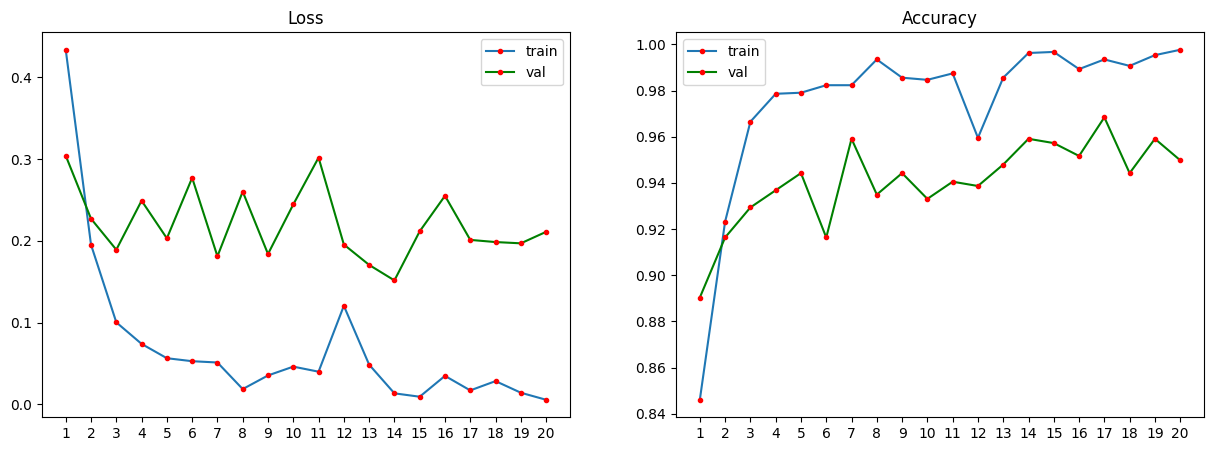

In [38]:
train(model, train_loader, val_loader, criterion, 'all')

begin training process


  5%|▌         | 1/20 [00:12<04:06, 12.97s/it]

Epoch 1 / 20 
 Training loss: 1.4011012694449854 - Other training metrics: 
{'accuracy_score': 0.8722958827634334, 'f1_score': 0.579119942607046}
 
 Validation loss : 0.18158688481040386 - Other validation metrics:
{'accuracy_score': 0.935933147632312, 'f1_score': 0.727356777282483}


Validation accuracy= 0.935933147632312===> Save best epoch


 10%|█         | 2/20 [00:25<03:52, 12.93s/it]

Epoch 2 / 20 
 Training loss: 0.15972505029439094 - Other training metrics: 
{'accuracy_score': 0.9539427773900907, 'f1_score': 0.7958900916765941}
 
 Validation loss : 0.07566748473876601 - Other validation metrics:
{'accuracy_score': 0.9693593314763231, 'f1_score': 0.8348044342187826}


Validation accuracy= 0.9693593314763231===> Save best epoch


 15%|█▌        | 3/20 [00:38<03:38, 12.87s/it]

Epoch 3 / 20 
 Training loss: 0.07649312200595346 - Other training metrics: 
{'accuracy_score': 0.9874389392882066, 'f1_score': 0.9264004291453615}
 
 Validation loss : 0.06753142521081558 - Other validation metrics:
{'accuracy_score': 0.9805013927576601, 'f1_score': 0.8653052473602402}


Validation accuracy= 0.9805013927576601===> Save best epoch


 20%|██        | 4/20 [00:51<03:25, 12.87s/it]

Epoch 4 / 20 
 Training loss: 0.02673341134310923 - Other training metrics: 
{'accuracy_score': 0.9930216329378926, 'f1_score': 0.9571942360082206}
 
 Validation loss : 0.019367423152054503 - Other validation metrics:
{'accuracy_score': 0.9972144846796658, 'f1_score': 0.9775414451047857}




 25%|██▌       | 5/20 [01:04<03:14, 12.94s/it]

Epoch 5 / 20 
 Training loss: 0.011077190943670621 - Other training metrics: 
{'accuracy_score': 0.9972086531751571, 'f1_score': 0.9820313479623825}
 
 Validation loss : 0.019666727974528057 - Other validation metrics:
{'accuracy_score': 0.9944289693593314, 'f1_score': 0.9568924111431316}




 30%|███       | 6/20 [01:17<03:01, 12.94s/it]

Epoch 6 / 20 
 Training loss: 0.02657203488280985 - Other training metrics: 
{'accuracy_score': 0.994417306350314, 'f1_score': 0.9652100024277738}
 
 Validation loss : 0.011590918071864775 - Other validation metrics:
{'accuracy_score': 0.9972144846796658, 'f1_score': 0.9792784992784993}




 35%|███▌      | 7/20 [01:30<02:46, 12.84s/it]

Epoch 7 / 20 
 Training loss: 0.012374262825734731 - Other training metrics: 
{'accuracy_score': 0.9986043265875785, 'f1_score': 0.9908646980824153}
 
 Validation loss : 0.0542235006765076 - Other validation metrics:
{'accuracy_score': 0.9832869080779945, 'f1_score': 0.8885093167701863}




 40%|████      | 8/20 [01:43<02:34, 12.89s/it]

Epoch 8 / 20 
 Training loss: 0.017930383703022135 - Other training metrics: 
{'accuracy_score': 0.9972086531751571, 'f1_score': 0.9817293961648307}
 
 Validation loss : 0.03701335518422007 - Other validation metrics:
{'accuracy_score': 0.9832869080779945, 'f1_score': 0.895639534883721}




 45%|████▌     | 9/20 [01:56<02:22, 12.94s/it]

Epoch 9 / 20 
 Training loss: 0.017790909496344633 - Other training metrics: 
{'accuracy_score': 0.9951151430565248, 'f1_score': 0.9693141180753335}
 
 Validation loss : 0.013850988550543992 - Other validation metrics:
{'accuracy_score': 0.9972144846796658, 'f1_score': 0.9792784992784993}




 50%|█████     | 10/20 [02:08<02:08, 12.86s/it]

Epoch 10 / 20 
 Training loss: 0.005043471027497106 - Other training metrics: 
{'accuracy_score': 0.9993021632937893, 'f1_score': 0.9953936011880844}
 
 Validation loss : 0.022378937513250933 - Other validation metrics:
{'accuracy_score': 0.9888579387186629, 'f1_score': 0.9256728778467909}




 55%|█████▌    | 11/20 [02:21<01:55, 12.87s/it]

Epoch 11 / 20 
 Training loss: 0.004027891397185036 - Other training metrics: 
{'accuracy_score': 0.9993021632937893, 'f1_score': 0.9953936011880844}
 
 Validation loss : 0.009184427170973708 - Other validation metrics:
{'accuracy_score': 0.9972144846796658, 'f1_score': 0.9792784992784993}




 60%|██████    | 12/20 [02:34<01:42, 12.82s/it]

Epoch 12 / 20 
 Training loss: 0.014116595938232444 - Other training metrics: 
{'accuracy_score': 0.9986043265875785, 'f1_score': 0.9907083203651831}
 
 Validation loss : 0.02635775433157264 - Other validation metrics:
{'accuracy_score': 0.9916434540389972, 'f1_score': 0.9326243353143572}




 65%|██████▌   | 13/20 [02:47<01:30, 12.86s/it]

Epoch 13 / 20 
 Training loss: 0.00856895005417044 - Other training metrics: 
{'accuracy_score': 0.9986043265875785, 'f1_score': 0.9907083203651831}
 
 Validation loss : 0.019839203487798666 - Other validation metrics:
{'accuracy_score': 0.9916434540389972, 'f1_score': 0.9378354978354977}




 70%|███████   | 14/20 [03:00<01:17, 12.85s/it]

Epoch 14 / 20 
 Training loss: 0.32116820610912133 - Other training metrics: 
{'accuracy_score': 0.9378925331472435, 'f1_score': 0.7348354273524709}
 
 Validation loss : 0.32636625584291995 - Other validation metrics:
{'accuracy_score': 0.871866295264624, 'f1_score': 0.6263800904977375}


Validation accuracy= 0.871866295264624===> No saving


 75%|███████▌  | 15/20 [03:13<01:04, 12.81s/it]

Epoch 15 / 20 
 Training loss: 0.3055071223212636 - Other training metrics: 
{'accuracy_score': 0.9162595952547103, 'f1_score': 0.6970017338351588}
 
 Validation loss : 0.16055408394011017 - Other validation metrics:
{'accuracy_score': 0.9442896935933147, 'f1_score': 0.7578904774750472}


Validation accuracy= 0.9442896935933147===> No saving


 80%|████████  | 16/20 [03:26<00:51, 12.89s/it]

Epoch 16 / 20 
 Training loss: 0.07780760742167618 - Other training metrics: 
{'accuracy_score': 0.9811584089323099, 'f1_score': 0.8935566138177495}
 
 Validation loss : 0.03180308860354885 - Other validation metrics:
{'accuracy_score': 0.9888579387186629, 'f1_score': 0.9201867496665185}


Validation accuracy= 0.9888579387186629===> Save best epoch


 85%|████████▌ | 17/20 [03:38<00:38, 12.81s/it]

Epoch 17 / 20 
 Training loss: 0.042185725544794446 - Other training metrics: 
{'accuracy_score': 0.9902302861130495, 'f1_score': 0.9400719304115088}
 
 Validation loss : 0.05812761878839274 - Other validation metrics:
{'accuracy_score': 0.9777158774373259, 'f1_score': 0.8691690962099126}


Validation accuracy= 0.9777158774373259===> No saving


 90%|█████████ | 18/20 [03:51<00:25, 12.87s/it]

Epoch 18 / 20 
 Training loss: 0.016880949083078765 - Other training metrics: 
{'accuracy_score': 0.9937194696441033, 'f1_score': 0.9611705730930769}
 
 Validation loss : 0.016981777809072937 - Other validation metrics:
{'accuracy_score': 0.9944289693593314, 'f1_score': 0.9568924111431316}




 95%|█████████▌| 19/20 [04:04<00:12, 12.93s/it]

Epoch 19 / 20 
 Training loss: 0.006877215435034325 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.025544971267134158 - Other validation metrics:
{'accuracy_score': 0.9944289693593314, 'f1_score': 0.9600933748332592}




100%|██████████| 20/20 [04:17<00:00, 12.89s/it]

Epoch 20 / 20 
 Training loss: 0.004915427400619903 - Other training metrics: 
{'accuracy_score': 0.9993021632937893, 'f1_score': 0.9953936011880844}
 
 Validation loss : 0.017970688246594854 - Other validation metrics:
{'accuracy_score': 0.9972144846796658, 'f1_score': 0.9792784992784993}




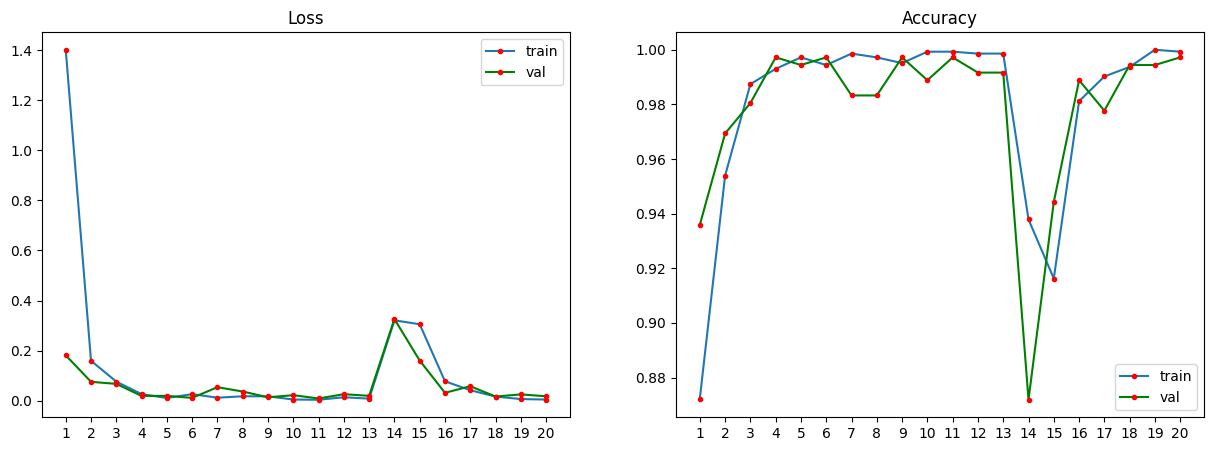

In [39]:
train(model_d3, train_loader_d3, val_loader_d3, criterion_d3, 'd3')

begin training process


  5%|▌         | 1/20 [00:06<02:00,  6.33s/it]

Epoch 1 / 20 
 Training loss: 1.1624735765460479 - Other training metrics: 
{'accuracy_score': 0.7280334728033473, 'f1_score': 0.7060690852749684}
 
 Validation loss : 0.47381702907159073 - Other validation metrics:
{'accuracy_score': 0.8379888268156425, 'f1_score': 0.8242781219322297}


Validation accuracy= 0.8379888268156425===> Save best epoch


 10%|█         | 2/20 [00:12<01:53,  6.30s/it]

Epoch 2 / 20 
 Training loss: 0.17192561307212798 - Other training metrics: 
{'accuracy_score': 0.9316596931659693, 'f1_score': 0.9277890708338385}
 
 Validation loss : 0.3624628354594989 - Other validation metrics:
{'accuracy_score': 0.8603351955307262, 'f1_score': 0.852994316875267}


Validation accuracy= 0.8603351955307262===> Save best epoch


 15%|█▌        | 3/20 [00:19<01:48,  6.41s/it]

Epoch 3 / 20 
 Training loss: 0.08922162290397548 - Other training metrics: 
{'accuracy_score': 0.9693165969316597, 'f1_score': 0.9671281863194572}
 
 Validation loss : 0.36468922279998156 - Other validation metrics:
{'accuracy_score': 0.8715083798882681, 'f1_score': 0.8624227234753551}


Validation accuracy= 0.8715083798882681===> Save best epoch


 20%|██        | 4/20 [00:25<01:43,  6.44s/it]

Epoch 4 / 20 
 Training loss: 0.0722917954708908 - Other training metrics: 
{'accuracy_score': 0.9776847977684798, 'f1_score': 0.9760561028552346}
 
 Validation loss : 0.318993824483496 - Other validation metrics:
{'accuracy_score': 0.9050279329608939, 'f1_score': 0.8969906232016519}


Validation accuracy= 0.9050279329608939===> Save best epoch


 25%|██▌       | 5/20 [00:32<01:37,  6.47s/it]

Epoch 5 / 20 
 Training loss: 0.03179756813322816 - Other training metrics: 
{'accuracy_score': 0.99302649930265, 'f1_score': 0.9924756481751611}
 
 Validation loss : 0.38441970073160553 - Other validation metrics:
{'accuracy_score': 0.8938547486033519, 'f1_score': 0.8856306957662172}




 30%|███       | 6/20 [00:38<01:30,  6.46s/it]

Epoch 6 / 20 
 Training loss: 0.0510352483770006 - Other training metrics: 
{'accuracy_score': 0.9832635983263598, 'f1_score': 0.9819562117272042}
 
 Validation loss : 0.3534876346462182 - Other validation metrics:
{'accuracy_score': 0.8938547486033519, 'f1_score': 0.8856306957662172}


Validation accuracy= 0.8938547486033519===> No saving


 35%|███▌      | 7/20 [00:44<01:23,  6.44s/it]

Epoch 7 / 20 
 Training loss: 0.0603885080029206 - Other training metrics: 
{'accuracy_score': 0.9762900976290098, 'f1_score': 0.9745396818765731}
 
 Validation loss : 0.4162819522692928 - Other validation metrics:
{'accuracy_score': 0.8715083798882681, 'f1_score': 0.8615529475064734}


Validation accuracy= 0.8715083798882681===> No saving


 40%|████      | 8/20 [00:51<01:16,  6.39s/it]

Epoch 8 / 20 
 Training loss: 0.07414493975820569 - Other training metrics: 
{'accuracy_score': 0.9707112970711297, 'f1_score': 0.9683459014911504}
 
 Validation loss : 0.3756189954205943 - Other validation metrics:
{'accuracy_score': 0.888268156424581, 'f1_score': 0.8820816864295126}


Validation accuracy= 0.888268156424581===> No saving


 45%|████▌     | 9/20 [00:57<01:10,  6.41s/it]

Epoch 9 / 20 
 Training loss: 0.04162317862788753 - Other training metrics: 
{'accuracy_score': 0.9860529986052998, 'f1_score': 0.9849876886484313}
 
 Validation loss : 0.45754764175989726 - Other validation metrics:
{'accuracy_score': 0.8994413407821229, 'f1_score': 0.8919951729686243}


Validation accuracy= 0.8994413407821229===> No saving


 50%|█████     | 10/20 [01:04<01:04,  6.44s/it]

Epoch 10 / 20 
 Training loss: 0.032592578319575495 - Other training metrics: 
{'accuracy_score': 0.9874476987447699, 'f1_score': 0.9864780763790664}
 
 Validation loss : 0.2693919942867372 - Other validation metrics:
{'accuracy_score': 0.9273743016759777, 'f1_score': 0.9231429798196651}




 55%|█████▌    | 11/20 [01:10<00:58,  6.45s/it]

Epoch 11 / 20 
 Training loss: 0.030840018106886864 - Other training metrics: 
{'accuracy_score': 0.9902370990237099, 'f1_score': 0.9894659074452254}
 
 Validation loss : 0.32925641762462915 - Other validation metrics:
{'accuracy_score': 0.9162011173184358, 'f1_score': 0.9108121574489287}




 60%|██████    | 12/20 [01:17<00:51,  6.40s/it]

Epoch 12 / 20 
 Training loss: 0.014389733766040646 - Other training metrics: 
{'accuracy_score': 0.9916317991631799, 'f1_score': 0.990963399879008}
 
 Validation loss : 0.3390947283557654 - Other validation metrics:
{'accuracy_score': 0.9162011173184358, 'f1_score': 0.9108121574489287}




 65%|██████▌   | 13/20 [01:23<00:44,  6.36s/it]

Epoch 13 / 20 
 Training loss: 0.015151312582050625 - Other training metrics: 
{'accuracy_score': 0.9944211994421199, 'f1_score': 0.9939950754593725}
 
 Validation loss : 0.38654613947857075 - Other validation metrics:
{'accuracy_score': 0.9217877094972067, 'f1_score': 0.9154520917678812}




 70%|███████   | 14/20 [01:29<00:38,  6.38s/it]

Epoch 14 / 20 
 Training loss: 0.017129265376583595 - Other training metrics: 
{'accuracy_score': 0.99302649930265, 'f1_score': 0.9924878202105925}
 
 Validation loss : 0.2923061652536689 - Other validation metrics:
{'accuracy_score': 0.9162011173184358, 'f1_score': 0.9108121574489287}




 75%|███████▌  | 15/20 [01:36<00:31,  6.39s/it]

Epoch 15 / 20 
 Training loss: 0.014313074679200302 - Other training metrics: 
{'accuracy_score': 0.9944211994421199, 'f1_score': 0.9939854039090681}
 
 Validation loss : 0.29187531666783695 - Other validation metrics:
{'accuracy_score': 0.8994413407821229, 'f1_score': 0.8919951729686243}




 80%|████████  | 16/20 [01:42<00:25,  6.39s/it]

Epoch 16 / 20 
 Training loss: 0.055863470099528675 - Other training metrics: 
{'accuracy_score': 0.9790794979079498, 'f1_score': 0.9775350134205057}
 
 Validation loss : 0.5118236785467103 - Other validation metrics:
{'accuracy_score': 0.8659217877094972, 'f1_score': 0.8568763326226013}


Validation accuracy= 0.8659217877094972===> No saving


 85%|████████▌ | 17/20 [01:48<00:19,  6.41s/it]

Epoch 17 / 20 
 Training loss: 0.04654802953515259 - Other training metrics: 
{'accuracy_score': 0.9762900976290098, 'f1_score': 0.9745396818765731}
 
 Validation loss : 0.2536746207105105 - Other validation metrics:
{'accuracy_score': 0.9162011173184358, 'f1_score': 0.9097084440259608}


Validation accuracy= 0.9162011173184358===> Save best epoch


 90%|█████████ | 18/20 [01:55<00:12,  6.38s/it]

Epoch 18 / 20 
 Training loss: 0.01752729758258514 - Other training metrics: 
{'accuracy_score': 0.99581589958159, 'f1_score': 0.9954926921263555}
 
 Validation loss : 0.2992515890465366 - Other validation metrics:
{'accuracy_score': 0.9106145251396648, 'f1_score': 0.9039957093054438}




 95%|█████████▌| 19/20 [02:01<00:06,  6.37s/it]

Epoch 19 / 20 
 Training loss: 0.013114792719545723 - Other training metrics: 
{'accuracy_score': 0.9944211994421199, 'f1_score': 0.9939854039090681}
 
 Validation loss : 0.41583389036992385 - Other validation metrics:
{'accuracy_score': 0.9050279329608939, 'f1_score': 0.894724096177132}




100%|██████████| 20/20 [02:08<00:00,  6.41s/it]

Epoch 20 / 20 
 Training loss: 0.025156283675792993 - Other training metrics: 
{'accuracy_score': 0.9902370990237099, 'f1_score': 0.9894659074452254}
 
 Validation loss : 0.2965108456991257 - Other validation metrics:
{'accuracy_score': 0.9106145251396648, 'f1_score': 0.9039957093054438}




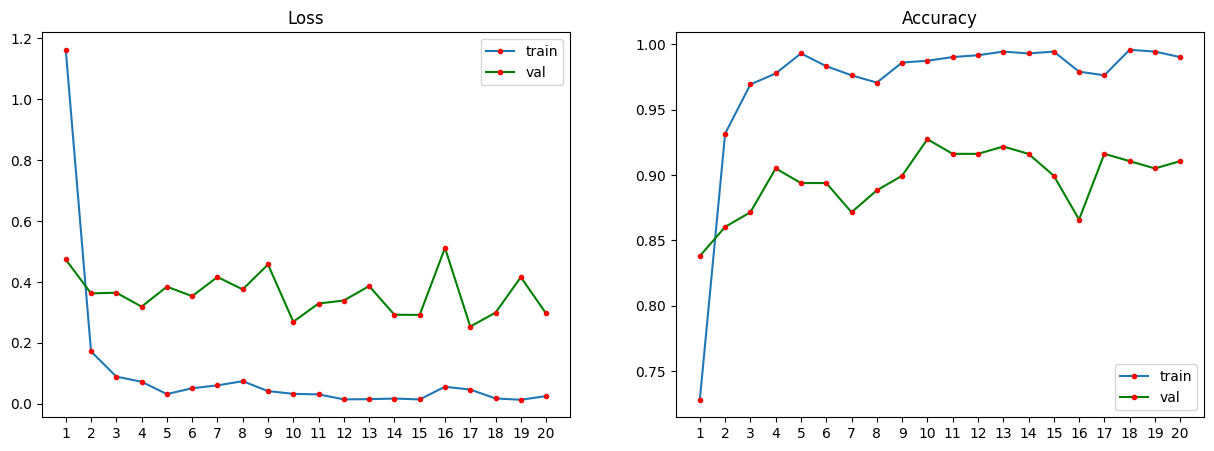

In [40]:
train(model_d5, train_loader_d5, val_loader_d5, criterion_d5, 'd5')

In [41]:
import copy
test_model = torch.load("/kaggle/working/best_all.pt")
test_model = test_model.to(device)
test_model_d3 = torch.load("/kaggle/working/best_d3.pt")
test_model_d3 = test_model_d3.to(device)
test_model_d5 = torch.load("/kaggle/working/best_d5.pt")
test_model_d5 = test_model_d5.to(device)

In [42]:
# threshold = 0.4 

def prediction(model, test_loader, device,name='no_tta_prob.npy'):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    aprobs = []
    with torch.no_grad():
        for data, target in test_loader:
            # move-tensors-to-GPU
            data = data.to(device)
#             print(data.shape)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
#             print(output.shape)
            prob = nn.Softmax(dim=1)
            # applying Softmax to results
            probs = prob(output)
#             print(probs.shape)
            aprobs.append(probs.cpu())
#             print(len(torch.argmax(probs, axis=1).tolist()))
            preds.extend(torch.argmax(probs, axis=1).tolist())
#             binary_predictions = (probs[:, 1] >= threshold).int()
#             preds.extend(binary_predictions.tolist())
#             print(len(preds))
    aprobs = np.array(aprobs)
    np.save(name,aprobs)
#     print(len(preds))
    return preds
data_test['prediction'] = prediction(test_model, test_loader, device,name='no_tta_prob.npy')
data_test

/tmp/ipykernel_32/2929763318.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  aprobs = np.array(aprobs)
/tmp/ipykernel_32/2929763318.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aprobs = np.array(aprobs)


,Image,Class,prediction
0,/kaggle/input/world-championship-2023-embryo-c...,0,0
1,/kaggle/input/world-championship-2023-embryo-c...,0,0
2,/kaggle/input/world-championship-2023-embryo-c...,0,0
3,/kaggle/input/world-championship-2023-embryo-c...,0,0
4,/kaggle/input/world-championship-2023-embryo-c...,0,0
...,...,...,...
163,/kaggle/input/world-championship-2023-embryo-c...,0,0
164,/kaggle/input/world-championship-2023-embryo-c...,0,1
165,/kaggle/input/world-championship-2023-embryo-c...,0,0
166,/kaggle/input/world-championship-2023-embryo-c...,1,1


In [43]:
data_test_d3['prediction'] = prediction(test_model_d3, test_loader_d3, device,name='no_tta_prob.npy')
data_test_d5['prediction'] = prediction(test_model_d5, test_loader_d5, device,name='no_tta_prob.npy')
data_test_all = pd.concat([data_test_d3, data_test_d5])
print(data_test_d3['prediction'].value_counts())
print(data_test_d5['prediction'].value_counts())
print(data_test_all['prediction'].value_counts())
data_test_all

/tmp/ipykernel_32/2929763318.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  aprobs = np.array(aprobs)
/tmp/ipykernel_32/2929763318.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aprobs = np.array(aprobs)


prediction
0    109
1      3
Name: count, dtype: int64
prediction
0    28
1    28
Name: count, dtype: int64
prediction
0    137
1     31
Name: count, dtype: int64


/tmp/ipykernel_32/2929763318.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  aprobs = np.array(aprobs)
/tmp/ipykernel_32/2929763318.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aprobs = np.array(aprobs)


,Image,Class,prediction
0,/kaggle/input/world-championship-2023-embryo-c...,0,0
1,/kaggle/input/world-championship-2023-embryo-c...,0,0
2,/kaggle/input/world-championship-2023-embryo-c...,0,0
3,/kaggle/input/world-championship-2023-embryo-c...,0,0
4,/kaggle/input/world-championship-2023-embryo-c...,0,0
...,...,...,...
51,/kaggle/input/world-championship-2023-embryo-c...,1,1
52,/kaggle/input/world-championship-2023-embryo-c...,0,0
53,/kaggle/input/world-championship-2023-embryo-c...,0,0
54,/kaggle/input/world-championship-2023-embryo-c...,0,1


In [44]:
# torch.save(model, f'test_model.pth')
import json
from sklearn.metrics import classification_report
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
def export_result(test, model_name):
    accuracy = accuracy_score(test['Class'].astype(float), test['prediction'].astype(float))
    precision = precision_score(test['Class'].astype(float), test['prediction'].astype(float), average='weighted')
    recall = recall_score(test['Class'].astype(float), test['prediction'].astype(float), average='weighted')
    f1score = f1_score(test['Class'].astype(float), test['prediction'].astype(float), average='weighted')
    
    results = {'accuracy': accuracy, 'f1score': f1score, 'precision': precision, 'recall': recall}
    with open(f'{model_name}_result.json', 'w') as f:
        json.dump(results, f)

    return results
export_result(data_test, 'mobilenet')

{'accuracy': 0.8809523809523809,
 'f1score': 0.8828225764845483,
 'precision': 0.8850425907163496,
 'recall': 0.8809523809523809}

In [45]:
print(export_result(data_test_d3, 'mobilenet_2model_d3'))
print(export_result(data_test_d5, 'mobilenet_2model_d5'))
export_result(data_test_all, 'mobilenet_2model_all')

{'accuracy': 0.9285714285714286, 'f1score': 0.919973544973545, 'precision': 0.9115334207077327, 'recall': 0.9285714285714286}
{'accuracy': 0.7142857142857143, 'f1score': 0.7202380952380951, 'precision': 0.7551020408163264, 'recall': 0.7142857142857143}


{'accuracy': 0.8571428571428571,
 'f1score': 0.8632653061224489,
 'precision': 0.8720777691816072,
 'recall': 0.8571428571428571}

In [46]:
D3 = data_test['Image'].apply(lambda x: 'D3_' in x)
data_test_d3 = data_test[D3]
export_result(data_test_d3, 'mobilenet_d3')

{'accuracy': 0.9375,
 'f1score': 0.9245391705069125,
 'precision': 0.9119318181818182,
 'recall': 0.9375}

In [47]:
D5 = data_test['Image'].apply(lambda x: 'D5_' in x)
data_test_d5 = data_test[D5]
export_result(data_test_d5, 'mobile_d5')

{'accuracy': 0.7678571428571429,
 'f1score': 0.7720919213456526,
 'precision': 0.7884792626728111,
 'recall': 0.7678571428571429}

In [48]:
# threshold = 0.4 

def test_result(model, test_loader, device,name='no_tta_prob.npy'):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    aprobs = []
    with torch.no_grad():
        for data in test_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            prob = nn.Softmax(dim=1)
            # applying Softmax to results
            probs = prob(output)
            aprobs.append(probs.cpu())
            preds.extend(torch.argmax(probs, axis=1).tolist())
#             binary_predictions = (probs[:, 1] >= threshold).int()
#             preds.extend(binary_predictions.tolist())
    aprobs = np.array(aprobs)
    np.save(name,aprobs)
    return preds

In [57]:
!pip install -q grad-cam

In [58]:
check_cam = 0

In [59]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

def cam_visualization(paths, model, title):
    fig, axes = plt.subplots(2, len(paths), figsize=(20, 6))
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    heat_maps = []
    for i, image_path in enumerate(paths):
        img = cv2.imread(image_path)
        #     greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
        img = cv2.resize(img, (256, 256))
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        image = Image.open(image_path)
        input_tensor = transform(image).unsqueeze(0)
        # Note: input_tensor can be a batch tensor with several images!

        # Construct the CAM object once, and then re-use it on many images:
        cam = GradCAM(model=model, target_layers=model.features[-1])

        targets = [ClassifierOutputTarget(1)]

        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        heat_maps.append(grayscale_cam)
        visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
        ax = axes[i]
        ax.imshow(visualization)  
        ax.set_title(image_path.split('/')[-1])
        ax.axis('off')  # Turn off axis labels
    
        ax2 = axes[i+5]
        ax2.imshow(grayscale_cam)
        ax2.set_title(image_path.split('/')[-1])
        ax2.axis('off')
    plt.suptitle('Grad-Cam with ' + title)
    plt.tight_layout()  # Adjust spacing between subplots for a better layout
    plt.savefig(title+'.png')
    plt.show()        


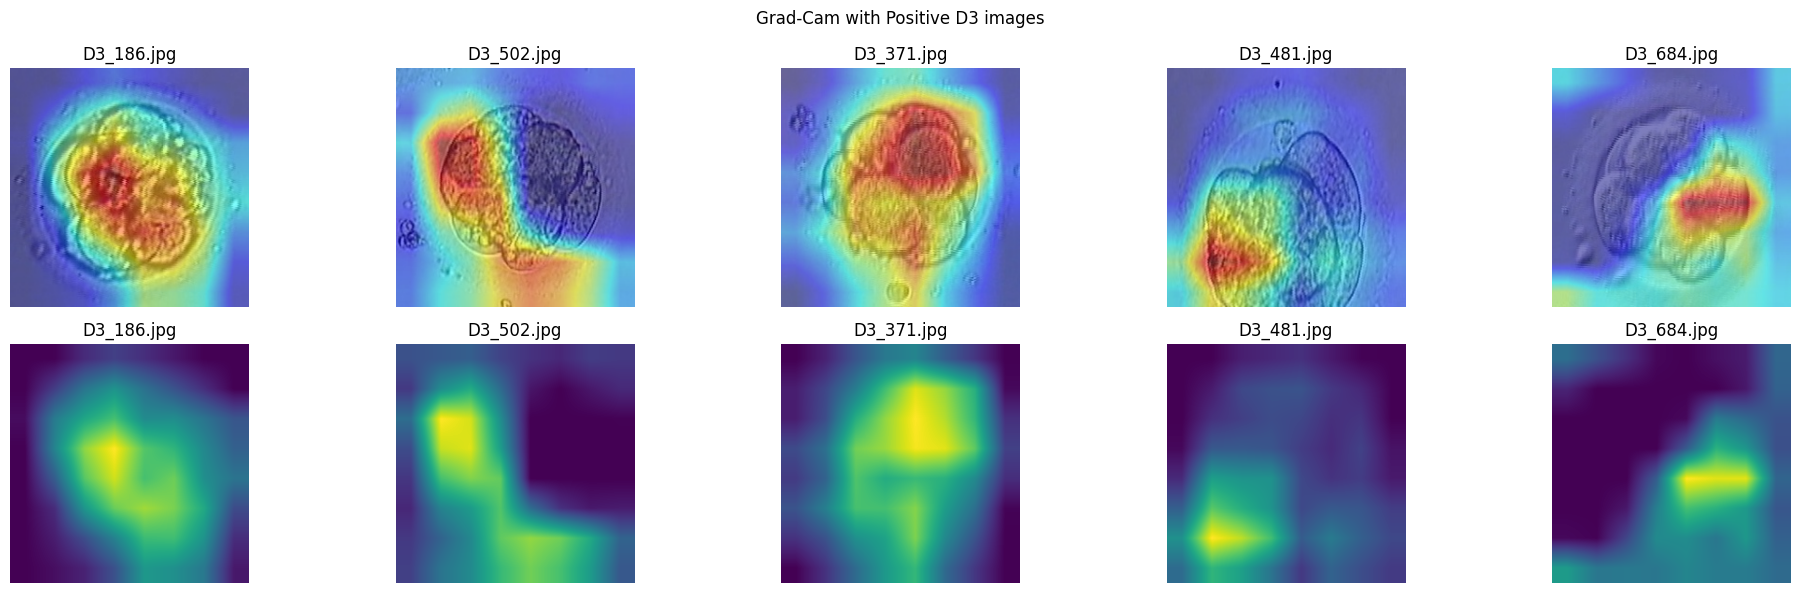

In [60]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_186.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_502.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_371.jpg',
              '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_481.jpg',
              '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_684.jpg']

heat = cam_visualization(image_paths, test_model, 'Positive D3 images')

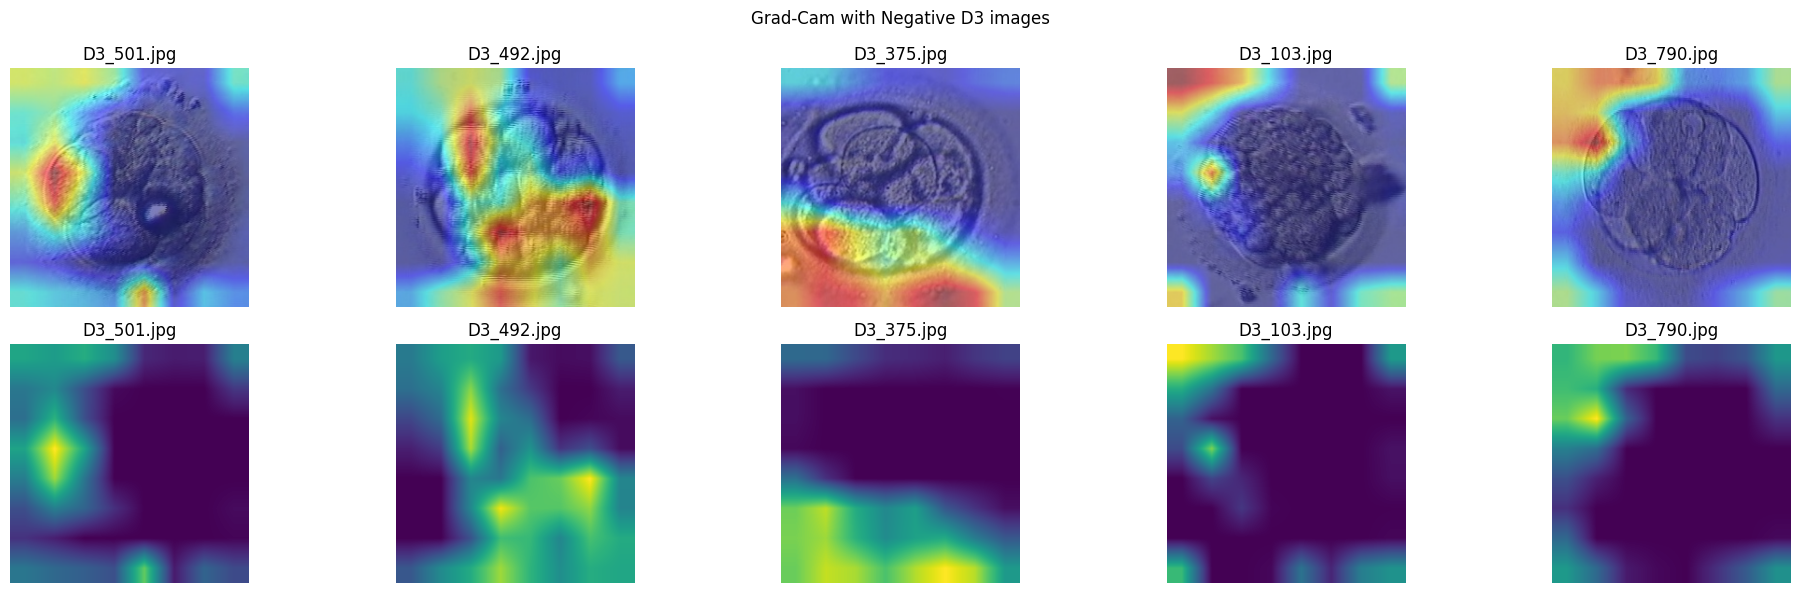

In [61]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_501.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_492.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_375.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_103.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_790.jpg']

cam_visualization(image_paths, test_model, 'Negative D3 images')

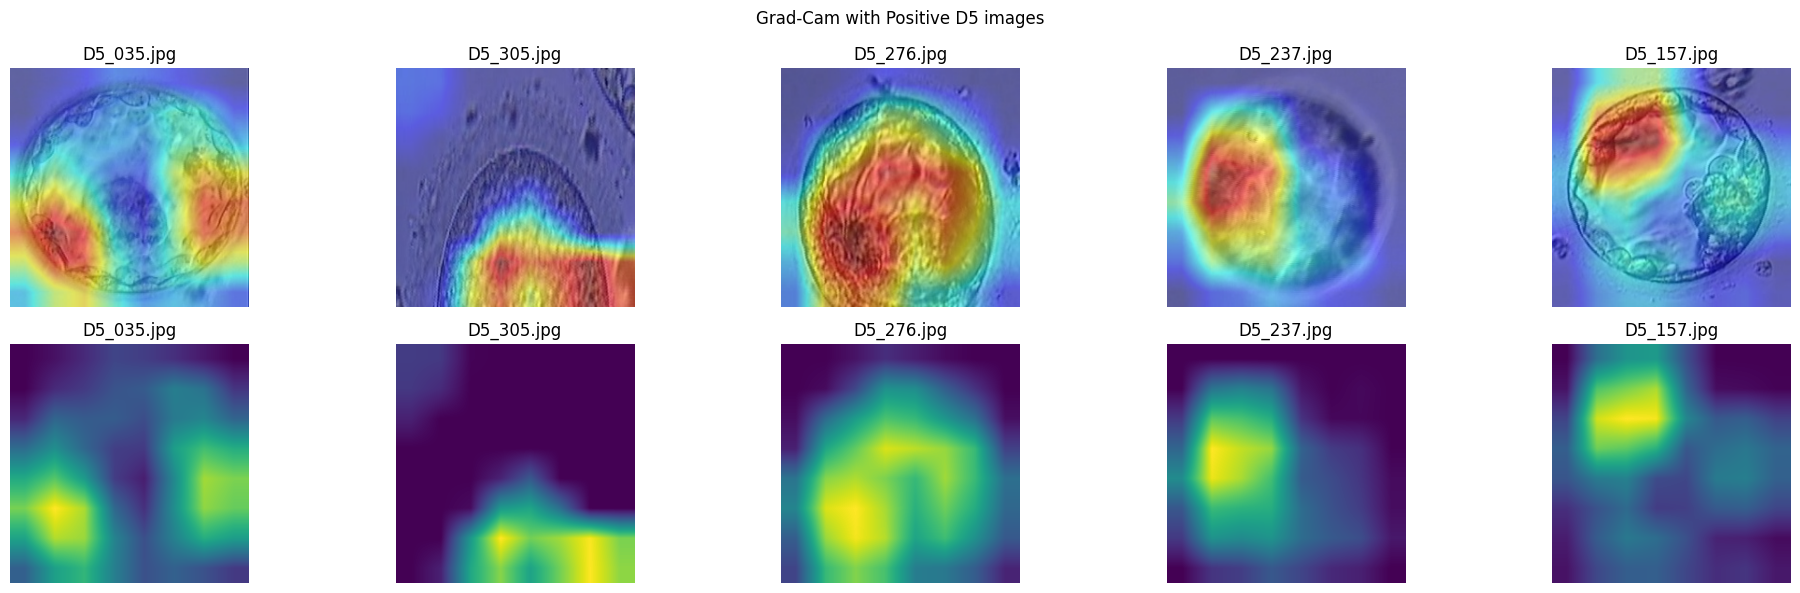

In [62]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_035.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_305.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_276.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_237.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_157.jpg']

cam_visualization(image_paths, test_model, 'Positive D5 images')

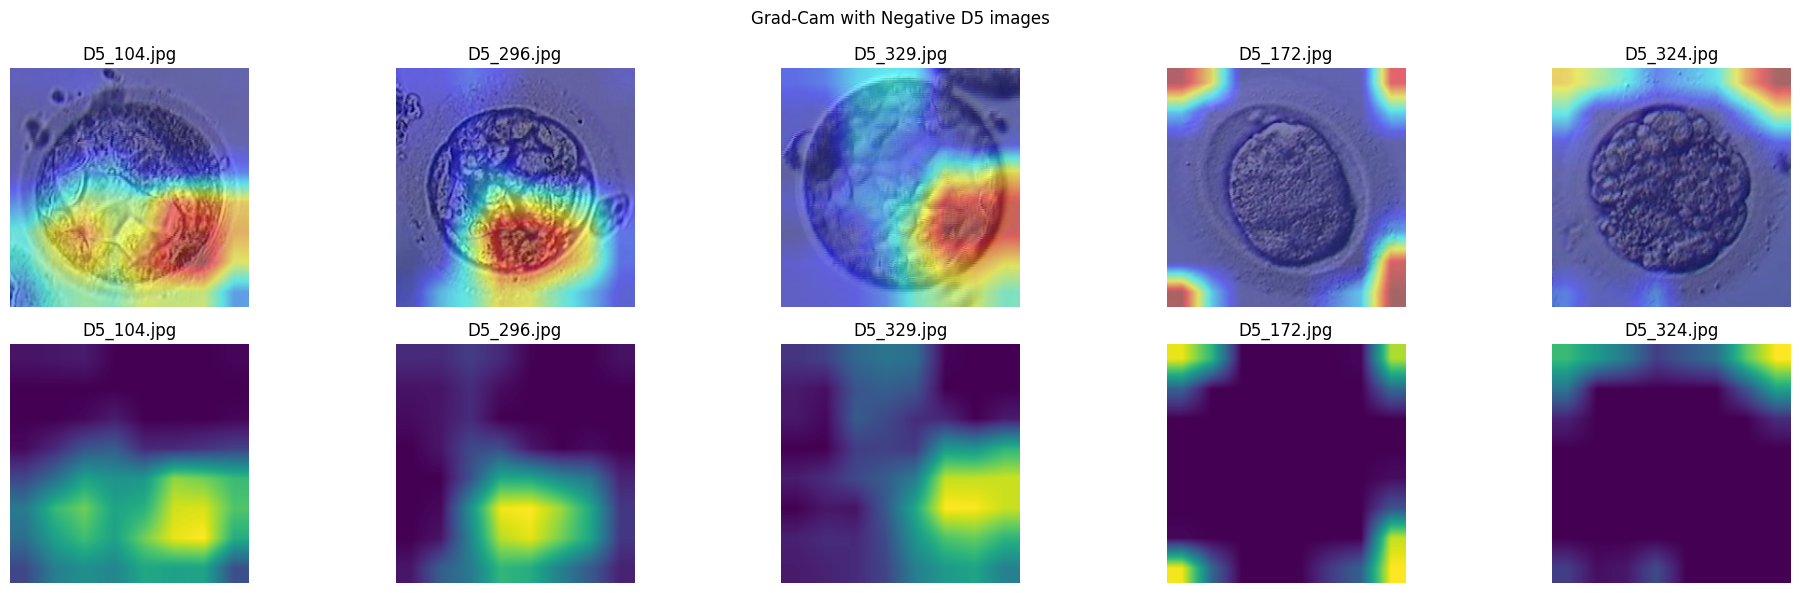

In [63]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_104.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_296.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_329.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_172.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_324.jpg']

cam_visualization(image_paths, test_model, 'Negative D5 images')

## Bootstrapping

In [64]:
data_train = pd.read_csv('/kaggle/input/embryo-split/train.csv')
data_val = pd.read_csv('/kaggle/input/embryo-split/test.csv')
data_val

,Image,Class
0,/kaggle/input/world-championship-2023-embryo-c...,0
1,/kaggle/input/world-championship-2023-embryo-c...,0
2,/kaggle/input/world-championship-2023-embryo-c...,0
3,/kaggle/input/world-championship-2023-embryo-c...,0
4,/kaggle/input/world-championship-2023-embryo-c...,0
...,...,...
163,/kaggle/input/world-championship-2023-embryo-c...,0
164,/kaggle/input/world-championship-2023-embryo-c...,0
165,/kaggle/input/world-championship-2023-embryo-c...,0
166,/kaggle/input/world-championship-2023-embryo-c...,1


In [65]:
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')# Load the iris dataset

def bootstrap(X, y, n_samples=2000):
    models = []
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(n_samples):
        if i % 10 == 0:
            print(i)
        X_bs, y_bs = resample(X, y, replace=True)
        bs_data = pd.concat([X_bs, y_bs], axis=1).reset_index().drop(columns=['index'])
#         print(bs_data)
        data_bs = ClassificationDataset(bs_data,data_path = "",transform=test_transform,training=True)
#         print('data: ', len(data_bs))
        dataloader_bs = torch.utils.data.DataLoader(data_bs, batch_size=1, shuffle=False)
#         data_bs = EmbryoData(bs_data, current_fold=0)
#         dataloader_bs = DataLoader(data_bs,batch_size = BATCH_SIZE, shuffle = False)
#         dataloader_bs = [(train_dataloader_d5, val_dataloader_d5)]
#         print(pd.DataFrame([X_bs, y_bs]))
        preds = prediction(test_model, dataloader_bs, device)
#         print(len(preds))
        accuracys.append(accuracy_score(bs_data['Class'].astype(float), preds))
        precisions.append(precision_score(bs_data['Class'].astype(float), preds, average='weighted'))
        recalls.append(recall_score(bs_data['Class'].astype(float), preds, average='weighted'))
        f1_scores.append(f1_score(bs_data['Class'].astype(float), preds, average='weighted'))

#         results = {'accuracy': accuracy, 'f1score': f1score, 'precision': precision, 'recall': recall}
#         print(results)
#         break
        
    # Save the results to a Pandas dataframe
    pred_df = pd.DataFrame(
        {
            "Accuracy": accuracys,
            "Precision": precisions,
            "Recall": recalls,
            "F1": f1_scores,
        }
    )
    pred_df.to_csv('boostraping.csv')
    return pred_df
    
bs_results = bootstrap(data_val['Image'], data_val['Class'], n_samples=2000)
bs_results

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


,Accuracy,Precision,Recall,F1
0,0.904762,0.912245,0.904762,0.907754
1,0.892857,0.887235,0.892857,0.886735
2,0.892857,0.892857,0.892857,0.892857
3,0.875000,0.876830,0.875000,0.875872
4,0.863095,0.870766,0.863095,0.866571
...,...,...,...,...
1995,0.910714,0.909147,0.910714,0.909876
1996,0.863095,0.903140,0.863095,0.878908
1997,0.863095,0.864921,0.863095,0.863968
1998,0.880952,0.877913,0.880952,0.879252


<Axes: xlabel='Precision', ylabel='Density'>

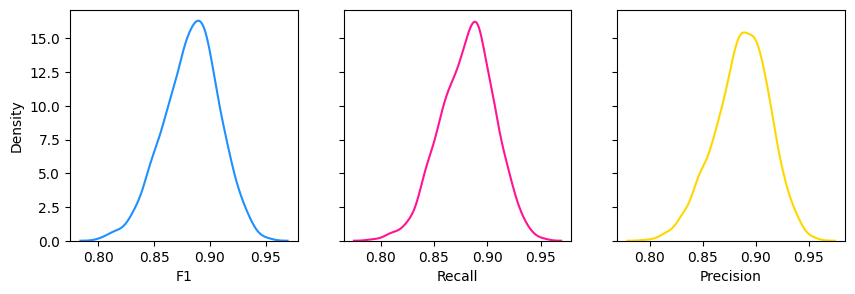

In [66]:
import seaborn as sns


# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(bs_results['F1'] , hist = False, color="dodgerblue", ax=axes[0])
sns.distplot(bs_results['Recall'] , hist = False, color="deeppink", ax=axes[1])
sns.distplot(bs_results['Precision'] , hist = False, color="gold", ax=axes[2])